In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/kernelddb044e506/params_epoch33_step32.dict
/kaggle/input/kernelddb044e506/params_epoch23_step9.dict
/kaggle/input/kernelddb044e506/params_epoch39_step29.dict
/kaggle/input/kernelddb044e506/params_epoch28_step19.dict
/kaggle/input/kernelddb044e506/params_epoch7_step32.dict
/kaggle/input/kernelddb044e506/params_epoch8_step29.dict
/kaggle/input/kernelddb044e506/params_epoch3_step9.dict
/kaggle/input/kernelddb044e506/params_epoch31_step32.dict
/kaggle/input/kernelddb044e506/params_epoch14_step32.dict
/kaggle/input/kernelddb044e506/params_epoch34_step19.dict
/kaggle/input/kernelddb044e506/params_epoch33_step19.dict
/kaggle/input/kernelddb044e506/params_epoch24_step9.dict
/kaggle/input/kernelddb044e506/params_epoch0_step9.dict
/kaggle/input/kernelddb044e506/params_epoch8_step19.dict
/kaggle/input/kernelddb044e506/params_epoch37_step32.dict
/kagg

In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_data['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [6]:
train_labels = train_data['label'].values
train_inputs,test_inputs = train_data.values[:,1:],test_data.values
train_inputs = train_inputs.reshape(-1,1,28,28)
test_inputs = test_inputs.reshape(-1,1,28,28)

In [7]:
#by analyze the plotted miss matched image, some images are rotated, erased partly, so add the augmentation accordingly
train_transform = transforms.Compose([
        transforms.ToPILImage(),
#       transforms.RandomApply(trans, p=0.5),
#        transforms.RandomResizedCrop(28, scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=2),
#        transforms.RandomPerspective(0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1), fillcolor=0),
#        transforms.RandomRotation(10, fill=(0,)), 
        transforms.ToTensor(),
#        transforms.RandomErasing(p=0.5, scale=(0.005, 0.01), ratio=(0.5, 2.0), value=0, inplace=False),
#        transforms.Normalize((0.1307,),(0.3081,))
    ])
    
val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
#        transforms.Normalize((0.1307,),(0.3081,))
    ])

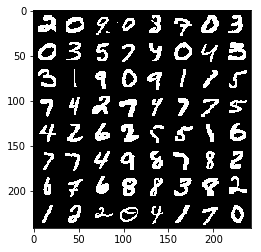

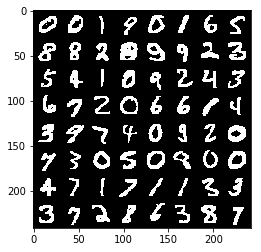

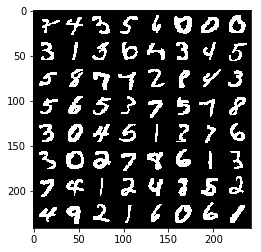

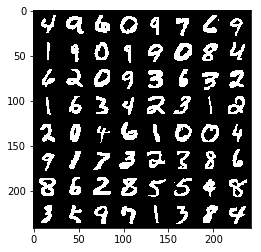

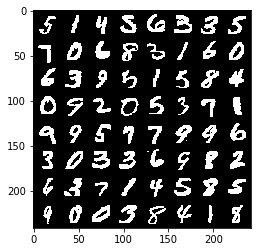

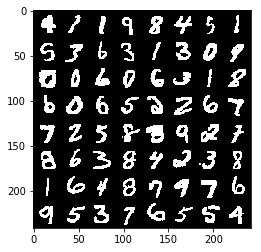

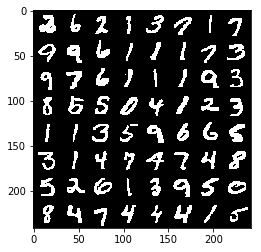

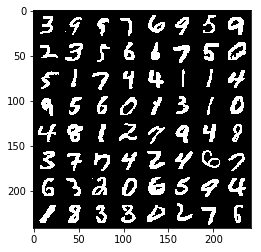

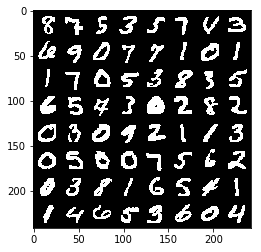

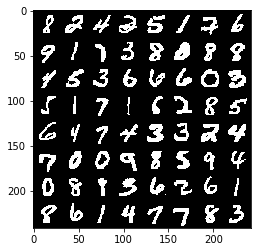

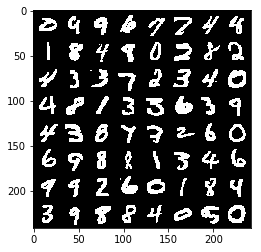

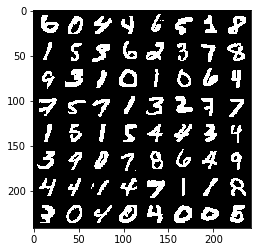

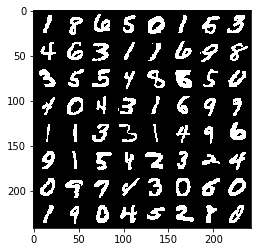

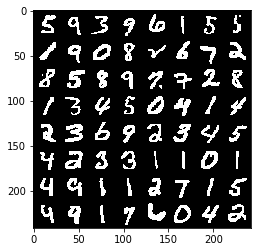

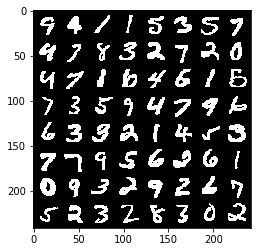

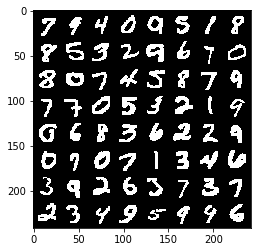

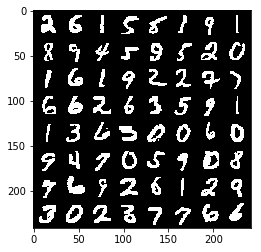

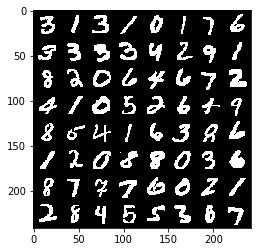

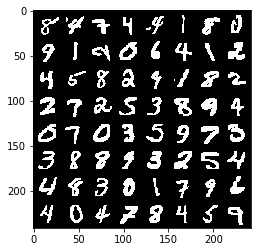

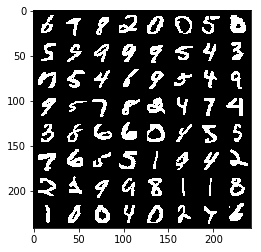

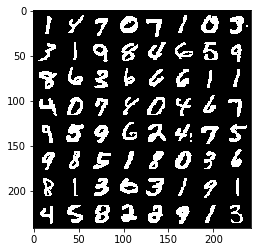

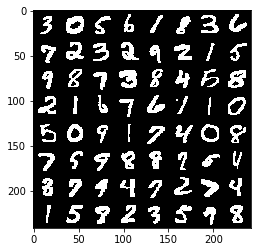

In [8]:
# Random split Dataset
train_labels = torch.from_numpy(train_labels).long()
train_inputs = torch.from_numpy(train_inputs).float()
test_inputs = torch.from_numpy(test_inputs).float()

init_dataset = Data.TensorDataset(
    train_inputs,
    train_labels
)
train_size = int(0.8 * len(init_dataset))
val_size = len(init_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(init_dataset, [train_size, val_size])

class MyDataset(Data.Dataset):
    def __init__(self, dataset, transformation = None):
        self.transformations = transformation
        self.dataset = dataset
        
    def __getitem__(self, index):
        self.inputs, self.labels = self.dataset[index]
        data = self.inputs
        if self.transformations is not None:
            data = self.transformations(data)
        return (data, self.labels)
 
    def __len__(self):
        return len(self.dataset)
    
train_dataset = MyDataset(train_dataset, train_transform)
val_dataset = MyDataset(val_dataset, val_transform)

class TestDataset(Data.Dataset):
    def __init__(self, inputs):
        self.transformations = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])
        self.inputs = inputs
        
    def __getitem__(self, index):
        # stuff
        data = self.inputs[index]
        data = self.transformations(data)
        return data
 
    def __len__(self):
        return len(self.inputs)

# Parameters
params_test = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 0}

# Generators
test_dataset = TestDataset(test_inputs)
test_loader = Data.DataLoader(test_dataset, **params_test)
#dataiter_test = iter(test_loader)
#images_test = next(dataiter_test)

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()*255.0
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# show images
for i,test_input in enumerate(test_loader):
    imshow(torchvision.utils.make_grid(test_input))
    if i > 20:
        break

In [9]:
# Parameters
params = {'batch_size': 1024,
          'shuffle': True,
          'num_workers': 0}
max_epochs = 200

# Generators
train_loader = Data.DataLoader(train_dataset, **params)
val_loader = Data.DataLoader(val_dataset, **params)

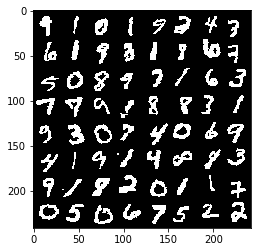

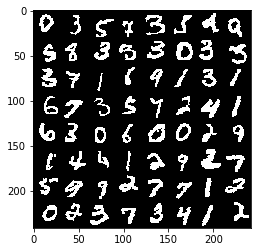

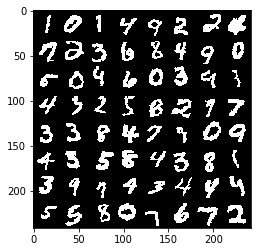

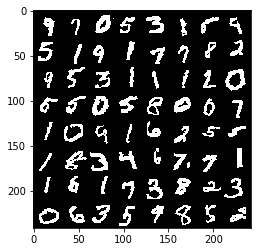

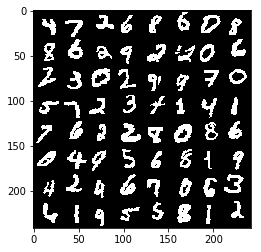

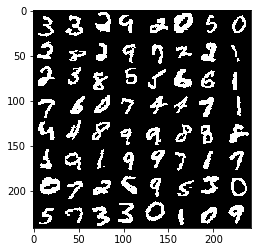

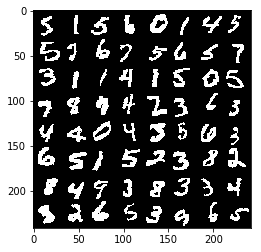

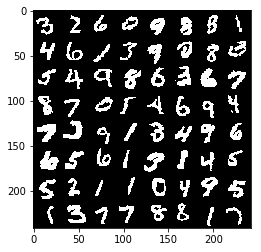

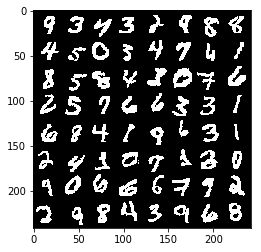

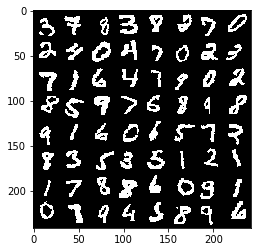

In [10]:
params_show = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}

# get some random training images
train_show_loader = Data.DataLoader(train_dataset, **params_show)
for i in range(10):
    dataiter = iter(train_show_loader)
    images, labels = next(dataiter)

    # show images
    imshow(torchvision.utils.make_grid(images))
# print labels
#print(labels.reshape(8,8))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv2_bn = nn.BatchNorm2d(32)
#        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 5, 2, 2)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.4)
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, 2, 2)
        self.conv6_bn = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)
        self.conv7 = nn.Conv2d(64, 128, 4, 1, 0)
        self.conv7_bn = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.dropout1(F.relu(self.conv3_bn(self.conv3(x))))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = self.dropout2(F.relu(self.conv6_bn(self.conv6(x))))
        x = F.relu(self.conv7_bn(self.conv7(x)))
        x = self.dropout3(x.view(-1, 128 * 4 * 4))
        x = self.fc1(x)
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#max_pred_ind = (97,9)
#PATH = '/kaggle/input/20200301digit-recognizer-params/20200301params_epoch97_ste{}-step{}.dict'.format(max_pred_ind[0],max_pred_ind[1])
#net.load_state_dict(torch.load(PATH))

In [12]:
min_loss = 1
min_loss_ind = 1
train_loss_list = []
val_loss_list = []
for epoch in range(max_epochs):
    running_loss = 0.0
    val_loss = 0.0
    for i, (train_inputs, train_labels) in enumerate(train_loader):
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(train_inputs.to(device))
        loss = criterion(outputs, train_labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % 10 == 9) or (i == len(train_loader)-1):    # print every 10 mini-batches and last mini-batch in an epoch
#            print('epoch{},step{} training loss: {}'.format(epoch, i, running_loss/10))            
            running_loss_val = 0.0
            if i == len(train_loader)-1:
                train_loss_list.append(running_loss/(len(train_loader)%10))
            else:
                train_loss_list.append(running_loss/10)
            correct = 0
            total = 0
            with torch.no_grad():
                net.eval()
                for data in val_loader:
                    val_inputs, val_labels = data
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = net(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    running_loss_val += val_loss.item()
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()
                acc = 100 * correct / total
                if min_loss > running_loss_val/len(val_loader):
                    min_loss = running_loss_val/len(val_loader)
                    min_loss_ind = (epoch, i)
                if i == len(train_loader)-1:
                    print('epoch{},step{} train loss: {}, val loss: {}'.format(epoch, i, running_loss/(len(train_loader)%10), running_loss_val/len(val_loader)))
                else:
                    print('epoch{},step{} train loss: {}, val loss: {}'.format(epoch, i, running_loss/10, running_loss_val/len(val_loader)))
                val_loss_list.append(running_loss_val/len(val_loader))
                print('Accuracy of the network on the validation images: {}%\n'.format(acc))
                torch.save(net.state_dict(),'params_epoch{}_step{}.dict'.format(epoch,i))
            running_loss = 0.0
            
print('min loss index', min_loss_ind, 'min loss', min_loss)

epoch0,step9 train loss: 2.0613017082214355, val loss: 2.742309331893921
Accuracy of the network on the validation images: 11.19047619047619%

epoch0,step19 train loss: 1.3541850566864013, val loss: 4.409832583533393
Accuracy of the network on the validation images: 11.214285714285714%

epoch0,step29 train loss: 0.950648409128189, val loss: 1.9613194200727675
Accuracy of the network on the validation images: 40.083333333333336%

epoch0,step32 train loss: 0.7605266571044922, val loss: 3.0990019109514026
Accuracy of the network on the validation images: 28.392857142857142%

epoch1,step9 train loss: 0.621169900894165, val loss: 1.6356127262115479
Accuracy of the network on the validation images: 50.345238095238095%

epoch1,step19 train loss: 0.47443003952503204, val loss: 0.8953664369053311
Accuracy of the network on the validation images: 72.83333333333333%

epoch1,step29 train loss: 0.3893490731716156, val loss: 0.700443340672387
Accuracy of the network on the validation images: 78.0%



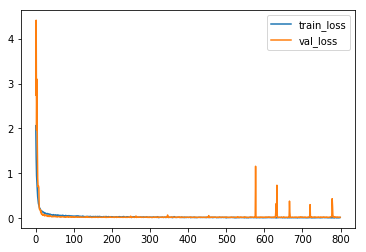

In [13]:
plt.plot(range(len(train_loss_list)),train_loss_list, label='train_loss')
plt.plot(range(len(train_loss_list)),val_loss_list, label='val_loss')
plt.legend()
plt.show()

PATH = '/kaggle/working/params_epoch{}_step{}.dict'.format(min_loss_ind[0],min_loss_ind[1])
net.load_state_dict(torch.load(PATH))

min_loss = 1
min_loss_ind = 1
train_loss_list = []
val_loss_list = []
for epoch in range(20):
    running_loss = 0.0
    val_loss = 0.0
    for i, (train_inputs, train_labels) in enumerate(train_loader):
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(train_inputs.to(device))
        loss = criterion(outputs, train_labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % 10 == 9) or (i == len(train_loader)-1):    # print every 10 mini-batches and last mini-batch in an epoch
#            print('epoch{},step{} training loss: {}'.format(epoch, i, running_loss/10))            
            running_loss_val = 0.0
            if i == len(train_loader)-1:
                train_loss_list.append(running_loss/(len(train_loader)%10))
            else:
                train_loss_list.append(running_loss/10)
            correct = 0
            total = 0
            with torch.no_grad():
                net.eval()
                for data in val_loader:
                    val_inputs, val_labels = data
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = net(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    running_loss_val += val_loss.item()
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()
                acc = 100 * correct / total
                if min_loss > running_loss_val/len(val_loader):
                    min_loss = running_loss_val/len(val_loader)
                    min_loss_ind = (epoch, i)
                if i == len(train_loader)-1:
                    print('epoch{},step{} train loss: {}, val loss: {}'.format(epoch, i, running_loss/(len(train_loader)%10), running_loss_val/len(val_loader)))
                else:
                    print('epoch{},step{} train loss: {}, val loss: {}'.format(epoch, i, running_loss/10, running_loss_val/len(val_loader)))
                val_loss_list.append(running_loss_val/len(val_loader))
                print('Accuracy of the network on the validation images: {}%\n'.format(acc))
                torch.save(net.state_dict(),'params_epoch{}_step{}.dict'.format(epoch,i))
            running_loss = 0.0
            
print('min loss index', min_loss_ind, 'min loss', min_loss)

#early stop and the optimal param is epoch12,step9 train loss: 0.020601647906005383, val loss: 0.025461613280432564
#Accuracy of the network on the validation images: 99.3452380952381%
min_loss_ind = (12,9)
PATH = '/kaggle/working/params_epoch{}_step{}.dict'.format(min_loss_ind[0],min_loss_ind[1])
net_optimal = Net().to(device)
net_optimal.load_state_dict(torch.load(PATH))
net_optimal.eval()
countError = 0

params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}
# Generators
val_loader = Data.DataLoader(val_dataset, **params)

with torch.no_grad():
    net.eval()
    for data in val_loader:
        val_inputs, val_labels = data
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = net(val_inputs)
        label = val_labels[0].item()
        _, predicted = torch.max(val_outputs.data, 1)
        if label != predicted:
            countError += 1
            imshow(torchvision.utils.make_grid(val_inputs))
print(countError)

In [14]:

PATH = 'params_epoch{}_step{}.dict'.format(min_loss_ind[0],min_loss_ind[1])
net_optimal = Net().to(device)
net_optimal.load_state_dict(torch.load(PATH))
net_optimal.eval()
test_outputs = []
with torch.no_grad():
    for test_input in test_loader:
        test_output = net_optimal(test_input.to(device))
        _, test_predicted = torch.max(test_output.data, 1)
        for test_pre in test_predicted.cpu().numpy():
            test_outputs.append(test_pre)

In [15]:
test_outputs = np.array(test_outputs)
test_outputs[0]
submit_result = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submit_result['Label'] = test_outputs
submit_result.to_csv('submit_result.csv',index=False)